# Stanford 40
### Download the data
You can see the zip files if you click the Files tab (looks like a folder symbol on the left of the screen)

In [ ]:
!wget http://vision.stanford.edu/Datasets/Stanford40_JPEGImages.zip
!wget http://vision.stanford.edu/Datasets/Stanford40_ImageSplits.zip

### Unzip it

In [ ]:
!unzip Stanford40_JPEGImages.zip -d Stanford40/
!unzip Stanford40_ImageSplits.zip -d Stanford40/

### Read the train and test splits and also create a separate labels lists

In [ ]:
with open('Stanford40/ImageSplits/train.txt', 'r') as f:
    train_files = list(map(str.strip, f.readlines()))
    train_labels = ['_'.join(name.split('_')[:-1]) for name in train_files]
    # print(f'Train files ({len(train_files)}):\n\t{train_files}')
    # print(f'Train labels ({len(train_labels)}):\n\t{train_labels}\n')

with open('Stanford40/ImageSplits/test.txt', 'r') as f:
    test_files = list(map(str.strip, f.readlines()))
    test_labels = ['_'.join(name.split('_')[:-1]) for name in test_files]
    # print(f'Test files ({len(test_files)}):\n\t{test_files}')
    # print(f'Test labels ({len(test_labels)}):\n\t{test_labels}\n')
    
action_categories = sorted(list(set(['_'.join(name.split('_')[:-1]) for name in train_files])))
# print(f'Action categories ({len(action_categories)}):\n{action_categories}')

### Visualize a photo from the training files and also print its label

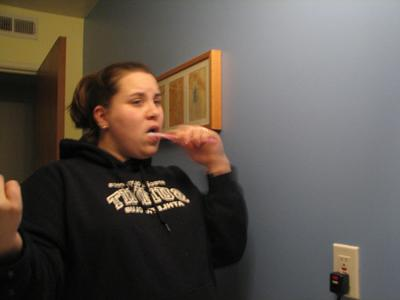

An image with the label - brushing_teeth


In [ ]:
import cv2
from google.colab.patches import cv2_imshow

image_no = 234  # change this to a number between [0, 3999] and you can see a different training image
img = cv2.imread(f'Stanford40/JPEGImages/{train_files[image_no]}')
cv2_imshow(img)
print(f'An image with the label - {train_labels[image_no]}')

# TV Human Interaction (TV-HI)
### Download the dataset

In [ ]:
!wget http://www.robots.ox.ac.uk/~alonso/data/tv_human_interactions_videos.tar.gz
!wget http://www.robots.ox.ac.uk/~alonso/data/readme.txt

### Untar compressed files and move the readme.txt into TV-HI folder

In [ ]:
!mkdir TV-HI
!tar -xvf  'tv_human_interactions_videos.tar.gz' -C TV-HI
!mv readme.txt 'TV-HI/readme.txt'

### Let us copy the Set 1 and Set 2 indices from the readme.txt and create our lists
You can check the readme.txt in TV-HI directory which you can find from the Files tab on the left (little Folder symbol). If you cannot see it try to refresh the Files tab (little folder symbol with a circular arrow on it). Then you can double click readme.txt to see its content. You won't need to do anything with this file because the code below creates the sets and labels for you.

In [11]:
set_1_indices = [[2,14,15,16,18,19,20,21,24,25,26,27,28,32,40,41,42,43,44,45,46,47,48,49,50],
                 [1,6,7,8,9,10,11,12,13,23,24,25,27,28,29,30,31,32,33,34,35,44,45,47,48],
                 [2,3,4,11,12,15,16,17,18,20,21,27,29,30,31,32,33,34,35,36,42,44,46,49,50],
                 [1,7,8,9,10,11,12,13,14,16,17,18,22,23,24,26,29,31,35,36,38,39,40,41,42]]
set_2_indices = [[1,3,4,5,6,7,8,9,10,11,12,13,17,22,23,29,30,31,33,34,35,36,37,38,39],
                 [2,3,4,5,14,15,16,17,18,19,20,21,22,26,36,37,38,39,40,41,42,43,46,49,50],
                 [1,5,6,7,8,9,10,13,14,19,22,23,24,25,26,28,37,38,39,40,41,43,45,47,48],
                 [2,3,4,5,6,15,19,20,21,25,27,28,30,32,33,34,37,43,44,45,46,47,48,49,50]]
classes = ['handShake', 'highFive', 'hug', 'kiss']  # we ignore the negative class

# test set
set_1 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_1_indices[c]]
set_1_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_1_indices[c]]
#print(f'Set 1 to be used for test ({len(set_1)}):\n\t{set_1}')
#print(f'Set 1 labels ({len(set_1_label)}):\n\t{set_1_label}\n')

# training set
set_2 = [f'{classes[c]}_{i:04d}.avi' for c in range(len(classes)) for i in set_2_indices[c]]
set_2_label = [f'{classes[c]}' for c in range(len(classes)) for i in set_2_indices[c]]
#print(f'Set 2 to be used for train and validation ({len(set_2)}):\n\t{set_2}')
#print(f'Set 2 labels ({len(set_2_label)}):\n\t{set_2_label}')


In [12]:
# from moviepy.editor import *

# video_no = 55  # change this to a number between [0, 100] and you can see a different training video from Set 2

# clip=VideoFileClip(f'TV-HI/tv_human_interactions_videos/{set_2[video_no]}')
# print(f'\n\nA video with the label - {set_2_label[video_no]}\n')
# clip.ipython_display(width=280)

# Stanford-40
All code to initialize our networks and helper functions

**Stanford-40**

In [34]:
# Stanford has 40 classes with 180-300 images per class (total of 9532 images).
# For validation, use 10% of training data with stratification
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import os
import cv2
import math 
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Dense, Dropout, AveragePooling2D, Conv3D, MaxPooling3D, Flatten, Conv2D, MaxPooling2D, BatchNormalization, average, add, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from moviepy.editor import *

In [3]:
# function that reads the images and resizes them 
# The labels are encoded and converted to one-hot encoding.
# The train and validaiton sets are returned
def preprocess_data(IMG_SIZE):
    label_enc = preprocessing.LabelEncoder()
    labels = label_enc.fit_transform(train_labels)  # transform to numbers
    train_images = []
    for img in train_files:
        im = cv2.imread(f'Stanford40/JPEGImages/' + img)
        im = cv2.resize(im, (IMG_SIZE, IMG_SIZE)) # resize to the correct size for EfficientNet
        train_images.append(im)
    x_train, x_val, y_train, y_val = train_test_split(train_images, labels, test_size=0.1, stratify=train_labels)
    x_train, x_val = np.array(x_train), np.array(x_val)
    y_train = to_categorical(y_train)
    y_val = to_categorical(y_val)
    return x_train, x_val, y_train, y_val


# https://proceedings.neurips.cc/paper/2014/file/00ec53c4682d36f5c4359f4ae7bd7ba1-Paper.pdf

def spatial_model():
  model = Sequential()
  model.add(Conv2D(128, kernel_size=(3,3), input_shape=(112,112,3), activation="relu"))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size=(3,3), activation="relu"))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(32, kernel_size=(3,3), activation="relu"))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(40, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=["accuracy"])
  model.summary()
  return model

def spatial_model_regularizer():

  model = Sequential()
  model.add(Conv2D(128, kernel_size=(3,3), input_shape=(112,112,3), activation="relu", kernel_regularizer='l2'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(64, kernel_size=(3,3), activation="relu", kernel_regularizer='l2'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())

  model.add(Conv2D(32, kernel_size=(3,3), activation="relu", kernel_regularizer='l2'))
  model.add(MaxPooling2D((2,2)))
  model.add(Dropout(0.3))
  model.add(BatchNormalization())
  
  model.add(Flatten())
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.5))
  model.add(Dense(40, activation="softmax"))
  model.compile(optimizer=Adam(learning_rate=1e-3), loss='categorical_crossentropy', metrics=["accuracy"])
  model.summary()
  return model


# plot the training and validation history
def plot_history(model, title, color):
    accuracy = model.history.history["accuracy"]
    val_accuracy = model.history.history["val_accuracy"]
    loss = model.history.history['loss']
    val_loss = model.history.history['val_loss']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, color, label='Training accuracy')
    plt.plot(epochs, val_accuracy, color+"--", label='Validation accuracy')
    plt.title('Training and validation accuracy for ' + title)
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, color, label='Training loss')
    plt.plot(epochs, val_loss, color+"--", label='Validation loss')
    plt.title('Training and validation loss for ' + title)
    plt.legend()
    plt.show()


In [ ]:
x_train, x_val, y_train, y_val = preprocess_data(IMG_SIZE=112)
print(x_train.shape)

(3600, 112, 112, 3)


A good combination of parameters is:
Adam(learning rate=1e-3), batch size=64, IMG_SIZE=112

Train the spatial model.


In [6]:
def train_spatial():
  model = spatial_model()
  callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1),
              ModelCheckpoint(monitor="val_loss", mode="min", filepath="Stanford40_ckpt", save_best_only=True,
                              save_weights_only=False, verbose=1)]

  hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=callbacks, epochs=20, batch_size=128, verbose=1)
  model.save("Stanford40model")
  plot_history(model, "Stanford 40 CNN", color="r")

# train the spatial model with a Cyclical Learning rate 
def train_spatial_cyclical__lr():
  import tensorflow_addons
  from tensorflow_addons.optimizers import CyclicalLearningRate as CL

  model = spatial_model()
  steps_per_epoch = len(x_train) // 128
  clr = CL(initial_learning_rate=1e-4,
    maximal_learning_rate=1e-2,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=2 * steps_per_epoch
  )
  model.compile(optimizer=Adam(clr), loss='categorical_crossentropy', metrics=["accuracy"])

  callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)]

  hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=callbacks, epochs=20, batch_size=128, verbose=1)
  model.save("Stanford40model_cyclical")
  plot_history(model, "Stanford 40 CNN with Cyclical LR", color="m")


# train the spatial model with L2 regularization
def train_spatial_regularizer():
  model = spatial_model()
  callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)]

  hist = model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=callbacks, epochs=20, batch_size=128, verbose=1)
  model.save("Stanford40model_regularizer")
  plot_history(model, "Stanford 40 CNN with kernel regularizer", color="k")

# use data augmentation for Stanford 40 
def train_data_augmentation():
  datagen = ImageDataGenerator(
    brightness_range=(0.2,1),
    rotation_range=5,  # randomly rotate image by up to some degrees
    width_shift_range=3,  # randomly shift along x
    height_shift_range=3,  # randomly shift along y
    shear_range=0.5,  # shearing image
    zoom_range=-0.0,  # zooming
    horizontal_flip=False,  # flip along y axis
    fill_mode='nearest')
  model = spatial_model()
  callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)]
  model.fit(datagen.flow(x_train, y_train, batch_size=128),
         validation_data=datagen.flow(x_val, y_val),
         steps_per_epoch=len(x_train) / 128, epochs=20, callbacks=callbacks)

  model.save("Stanford40model_augmentation")
  plot_history(model, "Stanford 40 CNN with data augmentation", color="c")
  
# test the spatial model 
# make sure to load the correct model 
def test_spatial(IMG_SIZE, model_path):
  
  label_enc = preprocessing.LabelEncoder()
  labels = label_enc.fit_transform(test_labels)  # transform to numbers
  test_images = []
  for img in test_files:
      im = cv2.imread(f'Stanford40/JPEGImages/' + img)
      im = cv2.resize(im, (IMG_SIZE, IMG_SIZE))
      test_images.append(im)
  x_test = np.array(test_images)
  y_test = to_categorical(labels)

  model = load_model(model_path)
  score = model.evaluate(x_test, y_test)
  return score



# Start training networks

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 110, 110, 128)     3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 55, 55, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 55, 55, 128)       0         
                                                                 
 batch_normalization (BatchN  (None, 55, 55, 128)      512       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 53, 53, 64)        73792     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 26, 26, 64)       0

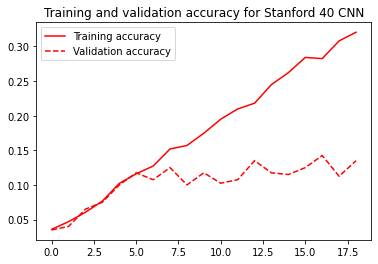

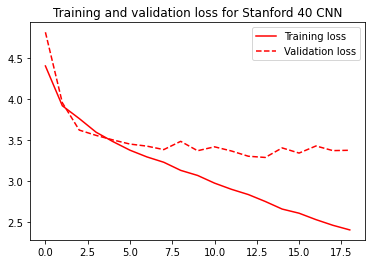

In [ ]:
train_spatial()
test_stanford(112, "Stanford40model")

In [ ]:
test_stanford(112, "Stanford40model")

173/173 [==============================] - 5s 27ms/step - loss: 3.3849 - accuracy: 0.1363


[3.3848986625671387, 0.13629789650440216]

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 110, 110, 128)     3584      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 55, 55, 128)      0         
 g2D)                                                            
                                                                 
 dropout_24 (Dropout)        (None, 55, 55, 128)       0         
                                                                 
 batch_normalization_16 (Bat  (None, 55, 55, 128)      512       
 chNormalization)                                                
                                                                 
 conv2d_13 (Conv2D)          (None, 53, 53, 64)        73792     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 26, 26, 64)      

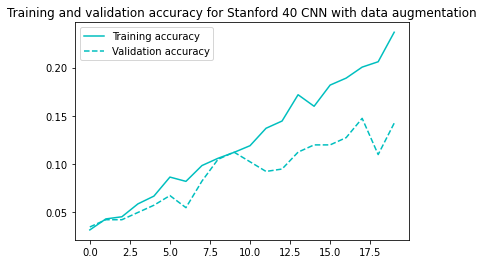

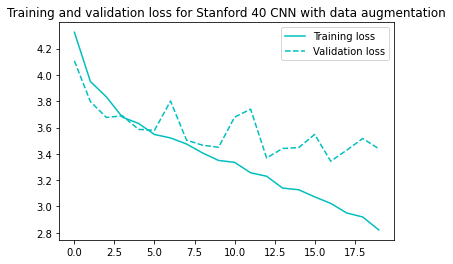

173/173 [==============================] - 5s 26ms/step - loss: 3.7472 - accuracy: 0.1095


[3.7471699714660645, 0.10954447090625763]

In [ ]:
train_data_augmentation()
test_stanford(112, "Stanford40model_augmentation")

In [ ]:
test_stanford(112, "Stanford40model_augmentation")

173/173 [==============================] - 5s 26ms/step - loss: 3.5238 - accuracy: 0.1260


[3.5237796306610107, 0.1259942203760147]

**TV-HI**

**Transfer Learning **

In [9]:
def get_middle_frame():
  """
  Function that calculates and saves the middle frame from TV_HI
  Saved inside tv_human_interactions_videos/middle_frame folder
  :param which_set: from the TV_HI set choose set_1 or set_2
  :return:
  """
  img_dir = '/content/TV-HI/tv_human_interactions_videos/'
  save_dir = img_dir+"middle_frames/"
  if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

  for video_no, video in enumerate(set_2):
    clip = img_dir + video
    label = set_2_label[video_no]
    cap = cv2.VideoCapture(clip)
    middle_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / 2)

    success, image = cap.read()
    count = 0
    success = True
    while success:
        success, image = cap.read()
        # when finding the middle frame
        if count == middle_frame:
            cv2.imwrite(save_dir+video.replace(".avi", '')+"_middle.jpg", image)
        count += 1

def get_middle_frame_test():
  """
  Function that calculates and saves the middle frame from TV_HI
  Saved inside tv_human_interactions_videos/middle_frame folder
  :param which_set: from the TV_HI set choose set_1 or set_2
  :return:
  """
  img_dir = '/content/TV-HI/tv_human_interactions_videos/'
  save_dir = img_dir+"middle_frames_test/"
  if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

  for video_no, video in enumerate(set_1):
    clip = img_dir + video
    label = set_1_label[video_no]
    cap = cv2.VideoCapture(clip)
    middle_frame = int(cap.get(cv2.CAP_PROP_FRAME_COUNT) / 2)

    success, image = cap.read()
    count = 0
    success = True
    while success:
        success, image = cap.read()
        # when finding the middle frame
        if count == middle_frame:
            cv2.imwrite(save_dir+video.replace(".avi", '')+"_middle.jpg", image)
        count += 1


In [13]:
get_middle_frame()
get_middle_frame_test()


In [18]:
def tvhi_model():
  inputs = Input(shape=(112, 112, 3))
  base_model = load_model('Stanford40model')
 
  for layers in base_model.layers[:-1]: #Freeze all layers except the last one
    layers.trainable=False

  base_model.pop() # remove last layer
  base_model.add(Flatten(name="flatten100"))
  base_model.add(Dense(64, activation="relu", name="dense10"))
  base_model.add(Dropout(0.5, name="dropout10"))
  base_model.add(BatchNormalization())
  base_model.add(Dense(40, activation="relu", name="dense20"))
  base_model.add(Dropout(0.5, name="dropout20"))
 
  
  base_model.add(Dense(4, activation="softmax")) #NOTE TTHE 1//10 learning rate of our original network is 1e-4
  base_model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=["accuracy"])
  base_model.summary()
  return base_model

def get_tvhi_frames(path):
  data, labels = [],[]
  for image_no, image in enumerate(sorted(os.listdir(path))):
    
    frame = cv2.imread(path+"/"+image)
    frame = cv2.resize(frame, (112,112))
    label = set_2_label[image_no]
    data.append(frame)
    labels.append(label)
  data = np.array(data)
  labels = np.array(labels)

  label_enc = preprocessing.LabelEncoder()
  labels = label_enc.fit_transform(labels) 
  labels = to_categorical(labels)

  x_train, x_val, y_train, y_val = train_test_split(data, labels, test_size=0.1, stratify= set_2_label)
  
  return x_train, x_val, y_train, y_val

def get_tvhi_frames_test(path):
  data, labels = [],[]
  for image_no, image in enumerate(sorted(os.listdir(path))):
    
    frame = cv2.imread(path+"/"+image)
    frame = cv2.resize(frame, (112,112))
    label = set_1_label[image_no]
    data.append(frame)
    labels.append(label)
  data = np.array(data)
  labels = np.array(labels)

  label_enc = preprocessing.LabelEncoder()
  labels = label_enc.fit_transform(labels) 
  labels = to_categorical(labels)

  return data, labels


def train_tvhi():
  model = tvhi_model()
  callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)]

  x_train_tvhi, x_val_tvhi,  y_train_tvhi, y_val_tvhi = get_tvhi_frames("/content/TV-HI/tv_human_interactions_videos/middle_frames/")
  print(x_train_tvhi.shape, y_train_tvhi.shape)
  
  hist = model.fit(x_train_tvhi, y_train_tvhi, validation_data=(x_val_tvhi, y_val_tvhi), callbacks=callbacks, 
                   epochs=100, verbose=1)
  model.save("TV_HImodel")
  plot_history(model, "TV_HI CNN", color="b")


# use data augmentation for TV-HI
def train_data_augmentation_tvhi():
  x_train_tvhi, x_val_tvhi, y_train_tvhi, y_val_tvhi = get_tvhi_frames("/content/TV-HI/tv_human_interactions_videos/middle_frames/")
  datagen = ImageDataGenerator(brightness_range=(0.2,1))
  model = tvhi_model()
  callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1)]
  model.fit(datagen.flow(x_train_tvhi, y_train_tvhi, batch_size=4), 
         validation_data=datagen.flow(x_val_tvhi, y_val_tvhi),
         steps_per_epoch=len(x_train_tvhi) / 4, epochs=100, callbacks=callbacks)

  model.save("TVHImodel_augmentation")
  plot_history(model, "TV HI CNN with data augmentation", color="g")

def test_tvhi_model(model_path):
  
  
  test_images = []
  test_images, labels = get_tvhi_frames_test("/content/TV-HI/tv_human_interactions_videos/middle_frames_test/")
  x_test = np.array(test_images)
  model = load_model(model_path)
  score = model.evaluate(x_test, labels)
  return score


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 110, 110, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 55, 55, 128)       0         
                                                                 
 batch_normalization_3 (Batc  (None, 55, 55, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 53, 53, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 64)      

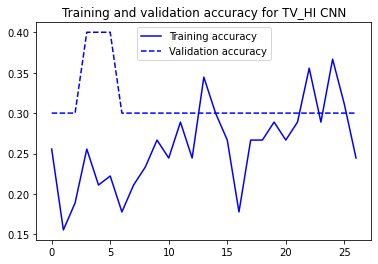

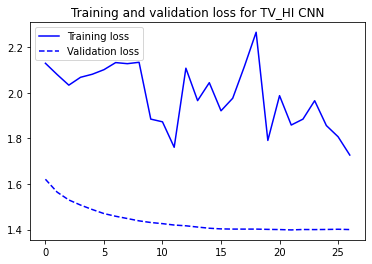

4/4 [==============================] - 0s 66ms/step - loss: 1.3994 - accuracy: 0.2600


[1.3993656635284424, 0.25999999046325684]

In [19]:
train_tvhi()
test_tvhi_model("TV_HImodel")

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 110, 110, 128)     3584      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 55, 55, 128)      0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 55, 55, 128)       0         
                                                                 
 batch_normalization_3 (Batc  (None, 55, 55, 128)      512       
 hNormalization)                                                 
                                                                 
 conv2d_4 (Conv2D)           (None, 53, 53, 64)        73792     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 26, 26, 64)      

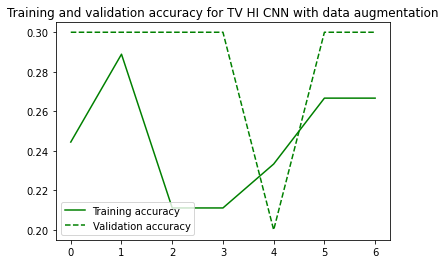

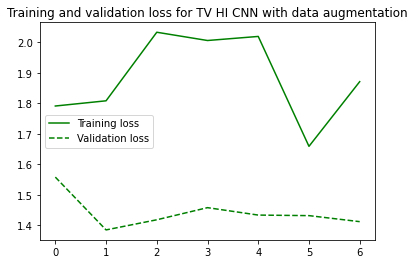

4/4 [==============================] - 0s 25ms/step - loss: 1.4482 - accuracy: 0.1900


[1.448190450668335, 0.1899999976158142]

In [20]:
train_data_augmentation_tvhi()
test_tvhi_model("TVHImodel_augmentation")

# Start of optical flow stuff
code of our optical flow CNN followed by the two stream network

*Optical* Flow Stuff

In [57]:
from google.colab.patches import cv2_imshow

# Function that returns how many frames we have to skip saving in order to always save 16 optical flow frames.
# Instead of saving the first or the last N frames, we try and take the ones that should be representative.
# Mean frame count per video is 103, Max frames is 301, min is 23

def skip_frame(frame_count):
  # because during optical the 1st image is used for calculation anyway
  skip = (frame_count-1) / 16 
  
  if skip%2 != 0: # is the number is odd
    skip = math.floor(skip)
  return skip 

# function that calculates the dense optical flow for the selected video frames  and saves it to corresponding folders
# Save 16-x and 16-y channel images, which can be considered as a 32 channel image
def optical_flow_calculation(img_dir, save_dir, which_set):
  if not os.path.isdir(save_dir):
    os.mkdir(save_dir)

  for video_no, video in enumerate(which_set):
    count = 0 # how many frames we have seen so far - gets back to 0 at some point
    looped = 0 # actual counter for the number of frames - used to save the image name

    clip = img_dir + video
    
    cap = cv2.VideoCapture(clip)
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) #total number of frames

    save_every = skip_frame(frame_count) # every how many frames we have to save the optical flow image 
    print("Saving every "+ str(save_every) + "/" + str(frame_count) + " frames")
    ret_flag, first_frame = cap.read()
    #count += 1
    #looped+=1
    # Converts frame to grayscale because we only need the luminance channel for detecting edges - less computationally xpensive
    prev_gray = cv2.cvtColor(first_frame, cv2.COLOR_BGR2GRAY)
      
    # Creates an image filled with zero# intensities with the same dimensions as the frame and set saturation to max
    mask = np.zeros_like(first_frame)
    mask[..., 1] = 255

    while(cap.isOpened()):
      ret_flag, frame = cap.read()
      if not ret_flag:
        print('No frames available!')
        break

      # cv2_imshow(frame)
      if frame != []:

        count += 1
        looped+=1

        # Converts each frame to grayscale
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

        # save every N frames and restart counter
        if count == save_every:
          flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)
          
          # Computes the magnitude and angle of the 2D vectors
          magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])
          
          # Sets image hue according to the optical flow  direction
          mask[..., 0] = angle * 180 / np.pi / 2
          
          # Sets image value according to the optical flow magnitude (normalized)
          mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)

        
          rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)

          # name of the path to save the optical flow images
          save_path = save_dir + video.replace('.avi', '') + "/"
          
          if not os.path.isdir(save_path):
            os.mkdir(save_path)
          cv2.imwrite(save_path + str(looped).zfill(4) +'.png', rgb)
          count = 0
      
      prev_gray = gray

  cap.release()
  cv2.destroyAllWindows()

In [65]:
def preprocess_opticalFlow(save_dir, which_set):
  """
  Reads the OF images and converts to numpy array.
  Encodes the labels into categorical vectors
  :param save_dir: the directory with the optical flow images
  :return: optical flow based train and validation set
  """

  if which_set == "set_1":
    which_labels = set_1_label
  elif which_set == "set_2":
    which_labels = set_2_label
  else:
    print('Wrong set in preprocess optical flow.')
    exit()

  optical_flow_data = []
  for folder in sorted(os.listdir(save_dir)):
    count = 0
    of_images = [] # optical flow images
    filepath = save_dir+folder+"/"
    for image in os.listdir(filepath):
      while count <=15:
        img_path = filepath+image
        im = cv2.imread(img_path)
        im = im.astype('float')
        im = cv2.resize(im, (112, 112))
        of_images.append(im)
        count+=1
    optical_flow_data.append(np.array(of_images)) # append all optical flow images to make training data array 

  label_enc = preprocessing.LabelEncoder()
  optical_flow_labels = label_enc.fit_transform(which_labels)  # transform to numbers
  optical_flow_labels = to_categorical(optical_flow_labels) # one-hot encoding
  #optical_flow_data = np.array(optical_flow_data)
  #optical_flow_labels = np.array(optical_flow_labels)

  return optical_flow_data, optical_flow_labels

# optical flow model
def of_model():
  model = Sequential()
  model.add(Conv3D(64, kernel_size=(3,3,3), padding="same"))
  model.add(MaxPooling3D((2,2,2)))
 

  model.add(Conv3D(32, kernel_size=(3,3,3), padding="same"))
  model.add(MaxPooling3D((2,2,2)))
  model.add(BatchNormalization(name="batchnorm1"))

  model.add(Conv3D(16, kernel_size=(3,3,3),  padding="same"))
  model.add(MaxPooling3D((2,2,2)))
  model.add(BatchNormalization(name="batchnorm2"))

  model.add(Flatten(name="flatten1"))
  model.add(Dense(64, activation="relu"))
  model.add(Dropout(0.5, name="dropout1"))

  model.add(Dense(4, activation="softmax", name="dense_final"))
  model.compile(optimizer=SGD(learning_rate=0.001,momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
  return model
 

def train_temporal_model(save_dir):
  """
  Calls optical flow calculation, preprocesses the optical flow data to split into train and validation and performs
  the training
  :param save_dir: The optical flow directory 
  :return: 
  """


  optical_flow_data, optical_flow_labels = preprocess_opticalFlow(save_dir, "set_2")
  x_train, x_val, y_train, y_val = train_test_split(optical_flow_data, optical_flow_labels, test_size=0.15, stratify=set_2_label)
  x_train = np.array(x_train)
  x_val = np.array(x_val)
  y_train = np.array(y_train)
  y_val = np.array(y_val)
  print(x_train.shape, x_val.shape, y_train.shape, y_val.shape)
  temporal_model = of_model()
  callbacks = [EarlyStopping(monitor="val_loss", mode="min", patience=5, verbose=1),
                ModelCheckpoint(monitor="val_loss", mode="min", filepath="TV_HI_OF_ckpt", save_best_only=True,
                                save_weights_only=False, verbose=1)]

  hist = temporal_model.fit(x_train, y_train, validation_data=(x_val, y_val), callbacks=callbacks, epochs=20, batch_size=16,
                      verbose=1)
  temporal_model.save("TV_HI_OF")
  plot_history(temporal_model, "TV-HI Optical Flow", color="g")


def test_of_model():
  """
  test optical_flow_model
  """
  x_test, y_test = preprocess_opticalFlow(save_dir_test, "set_1")
  temporal_model = of_model()
  score = temporal_model.evaluate(np.array(x_test), np.array(y_test))
  print("Test scores optical flow:", score)




In [ ]:
# import shutil
# shutil.rmtree("/content/TV-HI/optical_flow_train")

With the below code you have to run only once the optical_flow_calculation per set. So comment out if you already did it once.

In [66]:
import os
img_dir = '/content/TV-HI/tv_human_interactions_videos/'
save_dir_train = '/content/TV-HI/optical_flow_train/'
save_dir_test= '/content/TV-HI/optical_flow_test/'
# calculates the optical flow, saves to directory and trains the model
# if need to run the calculation


#optical_flow_calculation(img_dir, save_dir_train, set_2)
#optical_flow_calculation(img_dir, save_dir_test, set_1)
#train_temporal_model(save_dir_train)

# test it 

test_of_model()


4/4 [==============================] - 1s 216ms/step - loss: 19.4747 - accuracy: 0.2400
Test scores optical flow: [19.47466468811035, 0.23999999463558197]


# Two Stream Model

In [60]:
# function for the fusion of the two streams 
def two_stream_model():
  spatial_model = load_model("TV_HImodel")
  temporal_model = load_model("TV_HI_OF")
  # fused by taking average
  outputs = Concatenate()([spatial_model.output, temporal_model.output])

  x = Dense(20, name="denseAgain")(outputs)
  final_outputs = Dense(4, activation="softmax")(x)

  model = Model([spatial_model.input, temporal_model.input], final_outputs)

  return model


def get_data_two_stream(which_set):
  """
  Get optical flow and image data to train the two-stream model depending on the set.
  """
  static_image_stack, optical_flow_stack, labels = [],[], []
  static_frame_dir = "/content/TV-HI/tv_human_interactions_videos/middle_frames/"

  # given the set, find the list of labels 
  # set_1 is for testing
  # set_2 for training and validation
  if which_set == "set_1":
    which_labels = set_1_label
    optical_flow_dir = "/content/TV-HI/optical_flow_test/"
  elif which_set == "set_2":
    which_labels = set_2_label
    optical_flow_dir = "/content/TV-HI/optical_flow_train/"
  else:
    print('Wrong set in get data two stream')
    exit()

  # get the middle frames that were the input to the spatial model 
  for static_frame in sorted(os.listdir(static_frame_dir)):
    frame = cv2.imread(static_frame_dir+static_frame)
    frame = cv2.resize(frame, (112,112))
    static_image_stack.append(frame)

  # get the optical flow frrames per folder and stack them 
  # should be 15 per folder but let's just make sure with a counter
  for video_no, folder in enumerate(sorted(os.listdir(optical_flow_dir))):

    # get label
    label = which_labels[video_no]
    labels.append(label)

    count = 0
    of_images = [] # optical flow images
    filepath = optical_flow_dir+folder+"/"
    for image in os.listdir(filepath):
      while count <= 15:
        img_path = filepath+image
        im = cv2.imread(img_path)
        im = cv2.resize(im, (112,112))
        im = im.astype('float')
        
        of_images.append(im)
        count+=1
    optical_flow_stack.append(np.array(of_images))


  label_enc = preprocessing.LabelEncoder()
  labels = label_enc.fit_transform(labels) 
  labels = to_categorical(labels)
  
  return np.array(static_image_stack), np.array(optical_flow_stack), np.array(labels)

# training loop for the two stream model
def train_two_stream():
  static_images, optical_flow_images, labels = get_data_two_stream("set_2")
  # manually create training and validation sets
  x_train_static = static_images[0:75]
  x_val_static = static_images[76:99]
  x_train_of = optical_flow_images[0:75]
  x_val_of = optical_flow_images[76:99]
  y_train = labels[0:75]
  y_val = labels[76:99]
  
  print("Static images length:", static_images.shape)
  print("Optical flow images length:", optical_flow_images.shape)
  print("Label length:", labels.shape)
  model = two_stream_model()
  model.compile(optimizer=RMSprop(learning_rate=0.01), loss='categorical_crossentropy', metrics=['accuracy'])
  model.fit(x=[x_train_static, x_train_of], y=y_train, validation_data=([x_val_static, x_val_of], y_val), epochs=20, batch_size=25, verbose=1)
  model.save("TwoStreamModel")
  plot_history(model, "Two Stream model", color="c")

def test_two_stream():
  x_test_static, x_test_of, y_test = get_data_two_stream("set_1")
  print(x_test_static.shape, x_test_of.shape, y_test.shape)
  model = load_model("TwoStreamModel")
  score = model.evaluate([x_test_static, x_test_of], y_test)
  print("Two stream test score:", score)



Static images length: (100, 112, 112, 3)
Optical flow images length: (100, 16, 112, 112, 3)
Label length: (100, 4)
Epoch 1/20
3/3 [==============================] - 4s 954ms/step - loss: 1.2914 - accuracy: 0.3600 - val_loss: 2.0010 - val_accuracy: 0.0000e+00
Epoch 2/20
3/3 [==============================] - 2s 760ms/step - loss: 1.2510 - accuracy: 0.3467 - val_loss: 2.0374 - val_accuracy: 0.0000e+00
Epoch 3/20
3/3 [==============================] - 2s 762ms/step - loss: 1.2252 - accuracy: 0.3467 - val_loss: 2.0720 - val_accuracy: 0.0000e+00
Epoch 4/20
3/3 [==============================] - 2s 753ms/step - loss: 1.1945 - accuracy: 0.4267 - val_loss: 2.1053 - val_accuracy: 0.0000e+00
Epoch 5/20
3/3 [==============================] - 2s 760ms/step - loss: 1.1928 - accuracy: 0.4400 - val_loss: 2.1386 - val_accuracy: 0.0000e+00
Epoch 6/20
3/3 [==============================] - 2s 767ms/step - loss: 1.1556 - accuracy: 0.5067 - val_loss: 2.1700 - val_accuracy: 0.0000e+00
Epoch 7/20
3/3 [=====

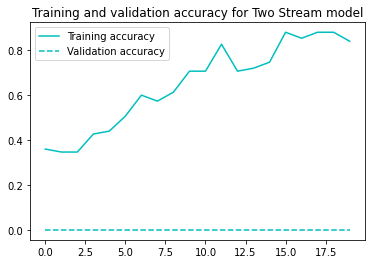

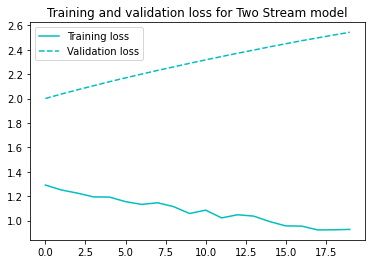

In [46]:
train_two_stream()

In [61]:
test_two_stream()

(100, 112, 112, 3) (100, 16, 112, 112, 3) (100, 4)
4/4 [==============================] - 2s 295ms/step - loss: 1.4276 - accuracy: 0.3800
Two stream test score: [1.4275587797164917, 0.3799999952316284]


# If you wanna zip 

In [ ]:
!zip -r '/content/"TV_HI_OF.zip"' '/content/TV_HI_OF'
!zip -r '/content/"TV_HImodel.zip"' '/content/TV_HImodel'
!zip -r '/content/"2stream.zip"' '/content/TwoStreamModel'